In [1]:
!pip install python-binance
!pip install data_cache

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.8/293.8 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 67.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Option valuation model based on historical prices

In [5]:
from datetime import datetime, timedelta, date
import os
import pandas
import binance
from data_cache import pandas_cache
import numpy
from numpy import ndarray
from matplotlib import pyplot
import math
import requests
from typing import Tuple

COUNT_YEARS = 10
BINANCE_DATETIME_FORMAT = "%Y-%m-%d %H-%M-%S"
BINANCE_SYMBOL = 'ETHUSDT'

os.environ['CACHE_PATH'] = '/content/drive/MyDrive/Colab Notebooks/Ethereum Prices'
os.environ['DISABLE_CACHE'] = 'FALSE'


def first_day_of_next_month(year: int, month: int):
  """Returns the first datetime of the next month.

  Args:
    year: The year.
    month: The month.

  Returns:
    A datetime object representing the first day of the next month.
  """

  next_month = month + 1
  if next_month > 12:
    next_month = 1
    year += 1
  return datetime(year, next_month, 1)


@pandas_cache("code", "year", "month")
def load_prices_by_month(code: str, year: int, month: int) -> pandas.DataFrame:
  binance_client = binance.Client()
  from_date = datetime(year, month, 1, 0, 0, 0)
  until_date = first_day_of_next_month(year, month) - timedelta(seconds=1)

  # Execute the query from binance - timestamps must be converted to strings !
  candles = binance_client.get_historical_klines(code, binance.Client.KLINE_INTERVAL_1HOUR, str(from_date), str(until_date))

  # Create a dataframe to label all the columns returned by binance so we work with them later.
  binance_prices = pandas.DataFrame(candles, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime',
                                          'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol',
                                          'ignore'])

  # as timestamp is returned in ms, let us convert this back to proper timestamps.
  binance_prices['open'] = binance_prices['open'].astype(float)
  binance_prices['high'] = binance_prices['high'].astype(float)
  binance_prices['low'] = binance_prices['low'].astype(float)
  binance_prices['close'] = binance_prices['close'].astype(float)
  binance_prices['volume'] = binance_prices['volume'].astype(float)
  binance_prices.dateTime = pandas.to_datetime(binance_prices.dateTime, unit='ms')
  binance_prices.set_index('dateTime', inplace=True)
  return binance_prices

In [6]:
current_year = datetime.now().year
df_by_period = list()
for year in range(current_year - COUNT_YEARS, current_year + 1):
    print(f'\nloading {year}', end=' ')
    for month in range(1, 13):
        if year == current_year and month == datetime.today().month:
            print(f'\ninterrupting at {year}/{month:02d}')
            break
        print('.', end='')
        df = load_prices_by_month(BINANCE_SYMBOL, year, month)
        df = df.drop(['closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'], axis=1)
        df_by_period.append(df)

prices_df = pandas.concat(df_by_period, axis=0)
prices_df.index = pandas.to_datetime(prices_df.index)

daily_prices = prices_df.groupby(prices_df.index.date)['open'].first()


loading 2013 .

BinanceAPIException: ignored

## Input parameters here

In [ ]:
target_period_days = 21
instrument_code = 'ETH'


headers = {"Content-Type": "application/json"}
base_url = 'https://www.deribit.com/api/v2/public'

get_options = f"{base_url}/get_instruments?currency={instrument_code}&kind=option&expired=false"
response_options = requests.get(get_options, headers=headers)
if response_options.status_code != 200:
    raise IOError(f'request failed with error {response_options.status_code}')

result = response_options.json()['result']
puts = {}
calls = {}
for option in result:
    if option['option_type'] == 'put':
        puts[(option['strike'], datetime.fromtimestamp(option['expiration_timestamp'] / 1000).date())] = option['instrument_id']
    elif option['option_type'] == 'call':
        calls[(option['strike'], datetime.fromtimestamp(option['expiration_timestamp'] / 1000).date())] = option['instrument_id']

target_expiry = min({k[1] for k in puts.keys()}, key=lambda d: abs(d - (date.today() + timedelta(days=target_period_days))))

get_current_price = f"{base_url}/get_index_price?index_name={instrument_code.lower()}_usd"
response_current_price = requests.get(get_current_price, headers=headers)

if response_current_price.status_code != 200:
    raise IOError(f'request failed with error {response_current_price.status_code}')

current_price = response_current_price.json()['result']['index_price']
remaining_days = (target_expiry - date.today()).days

## Draw-down probability

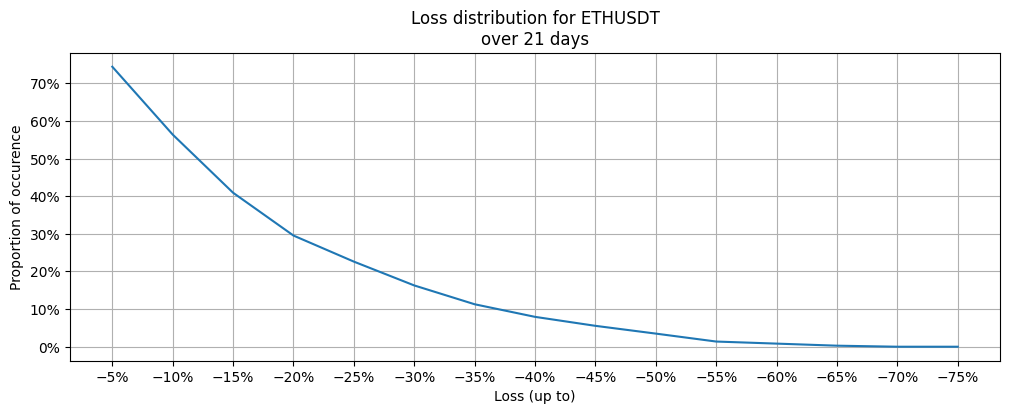

In [ ]:
rolling_min_series = prices_df.groupby(prices_df.index.date)['low'].min().rolling(remaining_days).min()
period_close_series = prices_df.groupby(prices_df.index.date)['close'].last().shift(-remaining_days)
period_close_dates = prices_df.groupby(prices_df.index.date)['close'].last().shift(-remaining_days).index
df = pandas.DataFrame({
    'daily_prices': daily_prices,
    'period_close_series': period_close_series,
    'rolling_min_series': rolling_min_series
})
df['rolling_min_series'] = df['rolling_min_series'].shift(-remaining_days)
df['drawdown_pct'] = -df['rolling_min_series'].divide(df['daily_prices']).subtract(1.).multiply(100.)
df['period_perf_pct'] = df['period_close_series'].divide(df['daily_prices']).subtract(1.).multiply(100.)
df.dropna(inplace=True)
df.index = pandas.to_datetime(df.index)
frequencies = dict()
for loss in range(5, 80, 5):
    frequencies[-loss] = 100. * df['drawdown_pct'][df['drawdown_pct'] > loss].count() / df['drawdown_pct'].count()

df = df[df.index.year>=2019]

from matplotlib import ticker
axes = pandas.Series(frequencies, name='loss_distribution').plot(
    figsize=(12,4),
    grid=True,
    xticks=list(frequencies.keys()),
    title=f'Loss distribution for {BINANCE_SYMBOL}\nover {remaining_days} days'
)
pyplot.gca().invert_xaxis()
pyplot.xlabel('Loss (up to)')
pyplot.ylabel('Proportion of occurence')
axes.xaxis.set_major_formatter(ticker.PercentFormatter())
axes.yaxis.set_major_formatter(ticker.PercentFormatter())

## Performance distribution

Text(0.5, 1.0, 'Period (21 days) Performance Underlying')

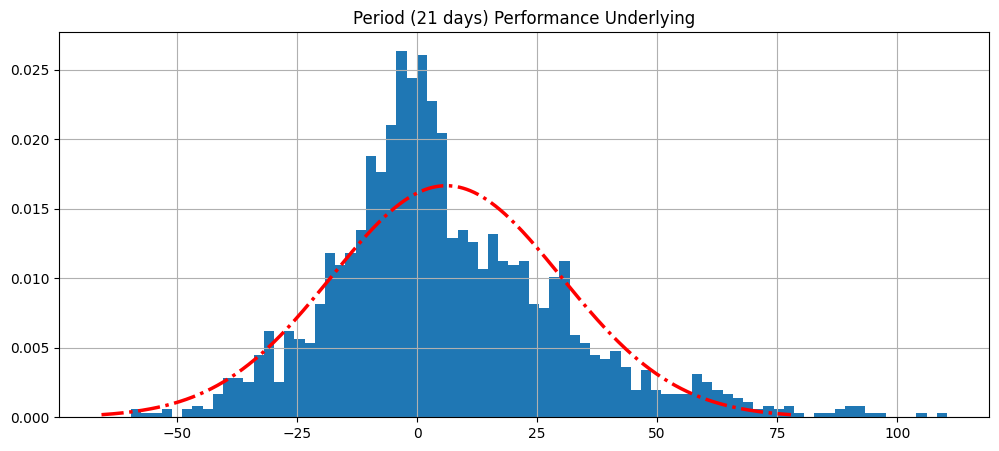

In [ ]:
df['period_perf_pct'].hist(bins=80, density=True, figsize=(12, 5))

def normpdf(x: ndarray, mu: float, sigma: float):
    sigma = abs(float(sigma))
    z = (x - float(mu)) / sigma
    return numpy.exp(-0.5 * numpy.square(z)) / (math.sqrt(2. * math.pi) * sigma)

mu = df['period_perf_pct'].describe()['mean']
sigma = df['period_perf_pct'].describe()['std']
# Generate the normal distribution curve
x = numpy.linspace(mu - 3 * sigma, mu + 3 * sigma, 1000)
y = normpdf(x, mu, sigma)

# Plot the normal distribution curve
pyplot.plot(x, y, linestyle='dashdot', linewidth=2.5, color='red')
pyplot.title(f'Period ({remaining_days} days) Performance Underlying')

Text(0.5, 1.0, 'Daily Performance Underlying')

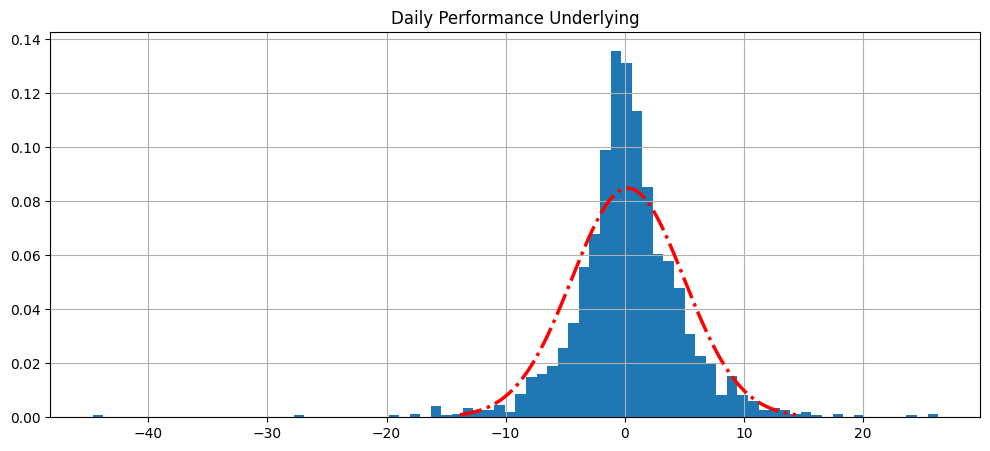

In [ ]:
daily_perf = df["daily_prices"].shift(-1).divide(df["daily_prices"]).subtract(1.).dropna().multiply(100.)
daily_perf.hist(bins=80, density=True, figsize=(12, 5))

mu = daily_perf.describe()['mean']
sigma = daily_perf.describe()['std']
# Generate the normal distribution curve
x = numpy.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
y = normpdf(x, mu, sigma)

# Plot the normal distribution curve
pyplot.plot(x, y, linestyle='dashdot', linewidth=2.5, color='red')
pyplot.title('Daily Performance Underlying')

## Option valuation model

<Axes: >

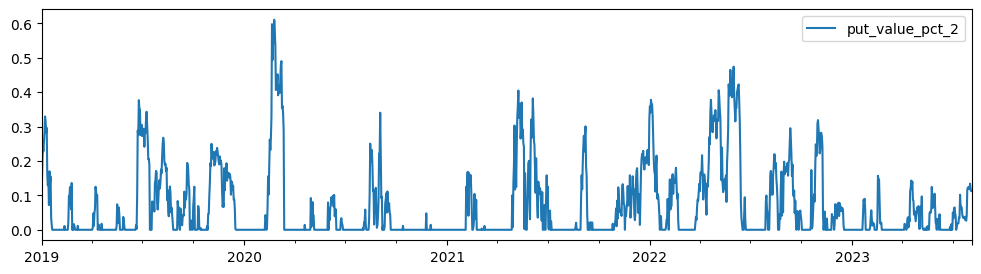

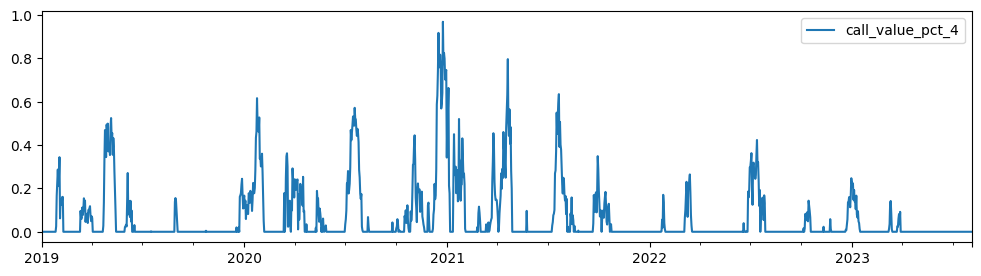

In [ ]:
def generate_strikes(price: float):
    closest_hundred = round(price / 100.) * 100.
    strikes = set()
    strikes.add(closest_hundred)
    for i in range(1, 3):
        strikes.add(closest_hundred + i * 100.)
        strikes.add(closest_hundred - i * 100.)

    return strikes

strike_prices = list(generate_strikes(current_price))
for count, strike_price in enumerate(strike_prices, start=1):
    strike_factor = strike_price / current_price
    df[f'strike_{count}'] = df['daily_prices'].multiply(strike_factor)
    df[f'strike_pct_{count}'] = strike_factor

    df[f'call_value_{count}'] = df['period_close_series'].subtract(df[f'strike_{count}'])
    df[f'call_value_{count}'].loc[df[f'call_value_{count}'] < 0.] = 0.
    df[f'call_value_pct_{count}'] = df[f'call_value_{count}'].divide(df['daily_prices'])

    df[f'put_value_{count}'] = df[f'strike_{count}'].subtract(df['period_close_series'])
    df[f'put_value_{count}'].loc[df[f'put_value_{count}'] < 0.] = 0.
    df[f'put_value_pct_{count}'] = df[f'put_value_{count}'].divide(df['daily_prices'])


df[['put_value_pct_2']].plot(figsize=(12,3))
df[['call_value_pct_4']].plot(figsize=(12,3))


In [ ]:
def load_bid_ask(options, strike: float, expiry: date) -> Tuple[float, float]:
    instrument_id = options[(strike, expiry)]
    get_bid_ask = f"{base_url}/get_order_book_by_instrument_id?instrument_id={instrument_id}&depth=1"
    response_bid_ask = requests.get(get_bid_ask, headers=headers)

    if response_bid_ask.status_code != 200:
        raise IOError(f'request failed with error {response_bid_ask.status_code}')

    bid_ask = response_bid_ask.json()['result']
    bid = ask = None
    if 'bids' in bid_ask and bid_ask['bids'] and bid_ask['bids'][0] and bid_ask['bids'][0][0]:
        bid = bid_ask['bids'][0][0]
    if 'asks' in bid_ask and bid_ask['asks'] and bid_ask['asks'][0] and bid_ask['asks'][0][0]:
        ask = bid_ask['asks'][0][0]
    return bid, ask

option_chain = list()
for count, strike_price in enumerate(strike_prices, start=1):
    put_bid, put_ask = load_bid_ask(puts, strike_price, target_expiry)
    call_bid, call_ask = load_bid_ask(calls, strike_price, target_expiry)
    strike_data = {
        'strike': strike_price,
        'value_call': df[f'call_value_pct_{count}'].mean() * current_price,
        'value_put': df[f'put_value_pct_{count}'].mean() * current_price,
        'value_call_median': df[f'call_value_pct_{count}'].quantile(0.5) * current_price,
        'value_put_median': df[f'put_value_pct_{count}'].quantile(0.5) * current_price,
        'value_call_pct': df[f'call_value_pct_{count}'].mean(),
        'call_ask': call_ask,
        'value_put_pct': df[f'put_value_pct_{count}'].mean(),
        'put_ask': put_ask
    }
    if strike_price < current_price:
        strike_data['value_call_pct'] = None
    if strike_price > current_price:
        strike_data['value_put_pct'] = None

    option_chain.append(strike_data)

option_chain_df = pandas.DataFrame(option_chain).set_index('strike').sort_index()
option_chain_df

,value_call,value_put,value_call_median,value_put_median,value_call_pct,call_ask,value_put_pct,put_ask
strike,,,,,,,,
1500.0,319.885388,43.471670,209.282142,0.000000,NaN,0.1185,0.025956,0.0060
1600.0,247.121692,70.707973,109.282142,0.000000,NaN,0.0685,0.042218,0.0135
1700.0,187.854517,111.440799,9.282142,0.000000,0.112163,0.0235,NaN,0.0385
1800.0,142.982802,166.569084,0.000000,90.717858,0.085372,0.0085,NaN,NaN
1900.0,107.362938,230.949220,0.000000,190.717858,0.064104,0.0039,NaN,NaN


In [ ]:
df

,daily_prices,period_close_series,rolling_min_series,drawdown_pct,period_perf_pct,strike_1,strike_pct_1,call_value_1,call_value_pct_1,put_value_1,...,call_value_4,call_value_pct_4,put_value_4,put_value_pct_4,strike_5,strike_pct_5,call_value_5,call_value_pct_5,put_value_5,put_value_pct_5
2019-01-01,131.45,117.81,111.39,15.260555,-10.376569,125.576924,0.955321,0.0,0.0,7.766924,...,0.0,0.0,31.312598,0.238209,117.728366,0.895613,0.081634,0.000621,0.000000,0.000000
2019-01-02,139.10,116.44,111.39,19.920920,-16.290439,132.885129,0.955321,0.0,0.0,16.445129,...,0.0,0.0,41.361090,0.297348,124.579808,0.895613,0.000000,0.000000,8.139808,0.058518
2019-01-03,152.01,116.39,111.39,26.721926,-23.432669,145.218321,0.955321,0.0,0.0,28.828321,...,0.0,0.0,56.056756,0.368770,136.142176,0.895613,0.000000,0.000000,19.752176,0.129940
2019-01-04,146.30,115.11,111.39,23.861928,-21.319207,139.763439,0.955321,0.0,0.0,24.653439,...,0.0,0.0,50.859083,0.347636,131.028224,0.895613,0.000000,0.000000,15.918224,0.108805
2019-01-05,152.08,115.34,111.39,26.755655,-24.158338,145.285193,0.955321,0.0,0.0,29.945193,...,0.0,0.0,57.186167,0.376027,136.204869,0.895613,0.000000,0.000000,20.864869,0.137197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,1861.79,1667.55,1550.00,16.746787,-10.432970,1778.606784,0.955321,0.0,0.0,111.056784,...,0.0,0.0,444.545556,0.238773,1667.443860,0.895613,0.106140,0.000057,0.000000,0.000000
2023-08-01,1856.13,1634.99,1550.00,16.492918,-11.914036,1773.199668,0.955321,0.0,0.0,138.209668,...,0.0,0.0,470.684606,0.253584,1662.374689,0.895613,0.000000,0.000000,27.384689,0.014754
2023-08-02,1873.48,1679.61,1550.00,17.266264,-10.348122,1789.774485,0.955321,0.0,0.0,110.164485,...,0.0,0.0,445.747200,0.237925,1677.913579,0.895613,1.696421,0.000905,0.000000,0.000000
2023-08-03,1839.90,1661.16,1550.00,15.756291,-9.714658,1757.694811,0.955321,0.0,0.0,96.534811,...,0.0,0.0,426.102588,0.231590,1647.838885,0.895613,13.321115,0.007240,0.000000,0.000000


In [ ]:
pnl = (df['put_value_pct_2'] + df['call_value_pct_4']).subtract(option_chain_df.iloc[1]['put_ask'] + option_chain_df.iloc[3]['call_ask'])

<Axes: >

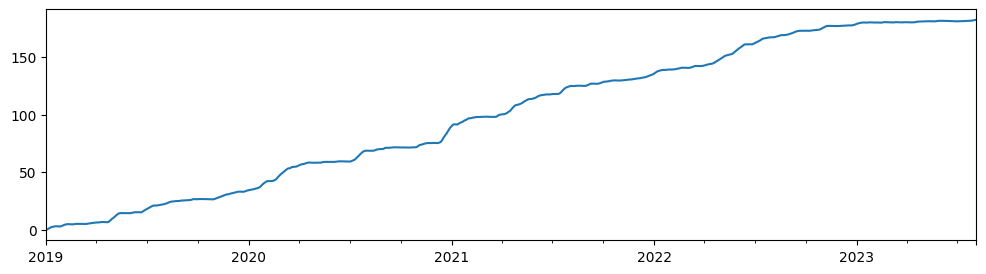

In [ ]:
pnl.cumsum().plot(figsize=(12,3))